# Homework 2

## Problem 1

Fit a linear basis function model or a kernel smoothing model to the data and tune the hyperparameters of the model. (Run at least 20 experiments.)

In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [2]:
# read the data from the csv file
data = pd.read_csv('../data/homework-2-data.csv')

# delete rows with duplicate X's
data = data.drop_duplicates(subset = 'X', keep = 'first')

# print the data
data

,X,Y
0,2.333,3.681
1,25.311,6.795
2,24.702,6.366
3,14.917,10.402
4,4.872,7.166
...,...,...
197,10.091,9.677
198,4.236,6.743
199,41.747,-5.310
200,43.194,-5.414


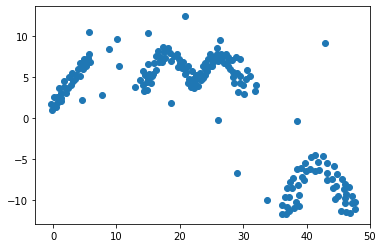

In [3]:
# extract the inputs X and outputs Y
X = data['X'].to_numpy()
Y = data['Y'].to_numpy()

# convert X to a n-by-1 matrix
X = np.atleast_2d(X).T

# plot the data
plt.scatter(X,Y)

I notice the data seems to have a lot of localized structure, which is a place where kernel smoothing is known to be effective, so let's try it. First, bring in the `KernelRegression` class from the lecture. (Week 3 - Lecture 7)

In [4]:
def GaussianKernel(x0, x, lam):
    return (1/lam) * np.exp(-np.linalg.norm(x0 - x) / (2 * lam ** 2))

class KernelRegression:
    def __init__(self, kernel_function, lam, fit_intercept = True):
        self.kernel_function = kernel_function
        self.fit_intercept = fit_intercept
        self.lam = lam

    def predict(self, x0, X, y):
        # find the number of X points
        n = X.shape[0]
        
        # add a column of ones if needed
        if self.fit_intercept:
            X = np.hstack((np.ones([n,1]), X))

        # construct the kernel matrix
        kernel = np.zeros([n, n])
        
        # populate the kernel matrix
        for i in range(n):
            kernel[i][i] = self.kernel_function(x0, X[i,:], self.lam)
        
        # return the prediction at point x0
        return np.array([1, np.float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y

Next, let's see if we can tune the hyperparameter $\lambda$ by splitting the data into training, dev, and test sets and running experiments on the dev set.

<ipython-input-4-a0d361ce9b83>:26: RuntimeWarning: overflow encountered in matmul
  return np.array([1, np.float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
<ipython-input-4-a0d361ce9b83>:26: RuntimeWarning: invalid value encountered in matmul
  return np.array([1, np.float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y


lambda: 0.187 		r^2: 0.955 		train MAE: 0.907 		dev MAE: 1.812
lambda: 0.222 		r^2: 0.951 		train MAE: 0.974 		dev MAE: 1.875
lambda: 0.257 		r^2: 0.946 		train MAE: 1.057 		dev MAE: 1.95
lambda: 0.291 		r^2: 0.94 		train MAE: 1.14 		dev MAE: 2.011
lambda: 0.326 		r^2: 0.934 		train MAE: 1.218 		dev MAE: 2.058
lambda: 0.361 		r^2: 0.928 		train MAE: 1.286 		dev MAE: 2.127
lambda: 0.396 		r^2: 0.922 		train MAE: 1.344 		dev MAE: 2.189
lambda: 0.43 		r^2: 0.916 		train MAE: 1.404 		dev MAE: 2.243
lambda: 0.465 		r^2: 0.911 		train MAE: 1.459 		dev MAE: 2.289
lambda: 0.5 		r^2: 0.906 		train MAE: 1.512 		dev MAE: 2.329


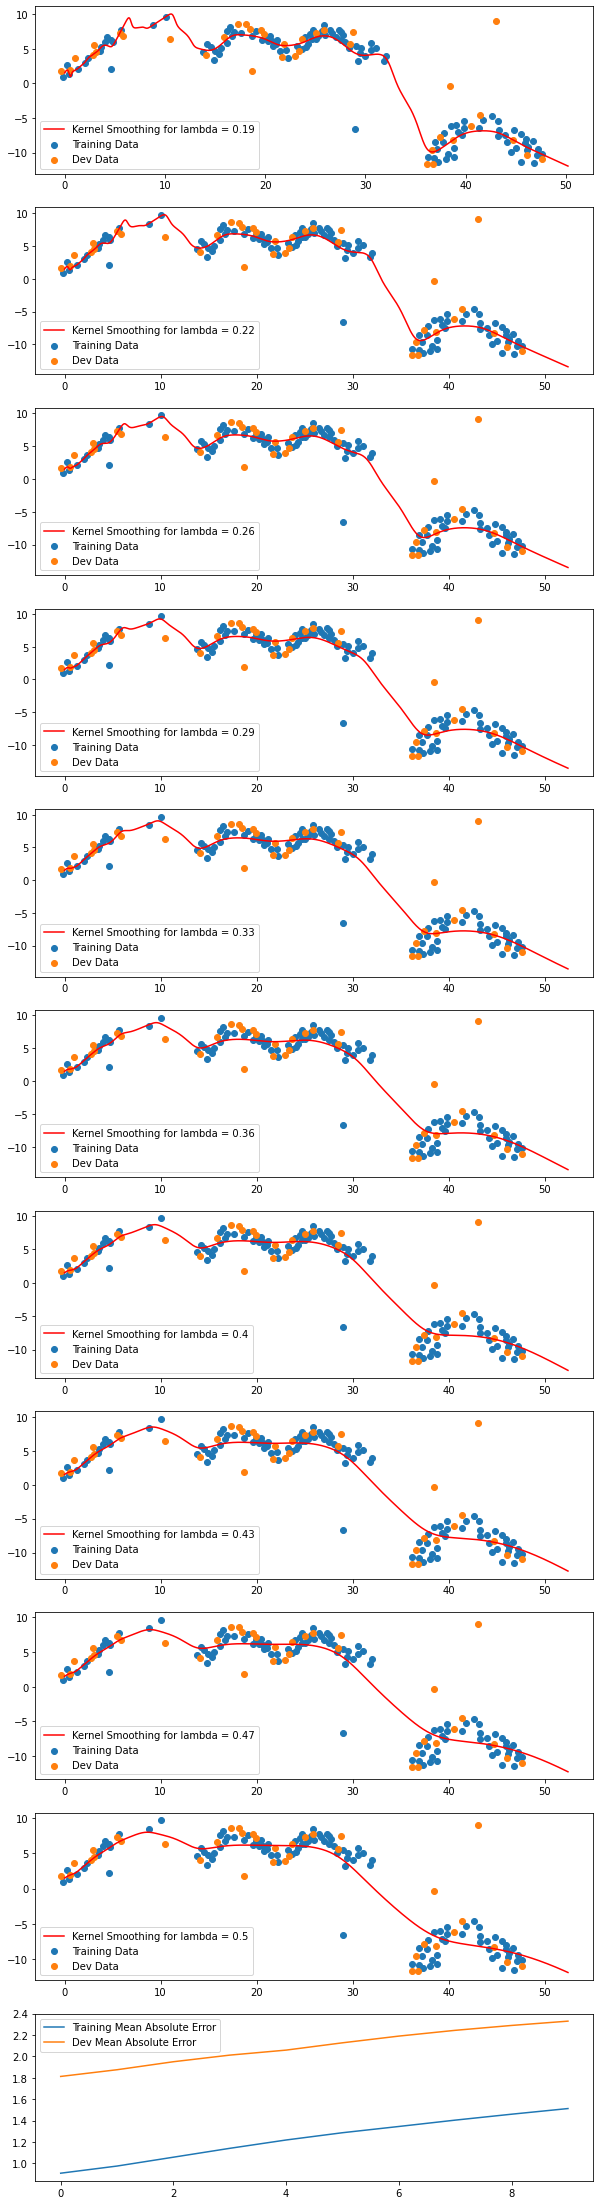

In [5]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.4)
devX, testX, devY, testY = train_test_split(testX, testY, test_size = 0.5)

lamValues = np.linspace(0.187, 0.5, 10)

M = lamValues.shape[0]

# allow multiple plots
fig, axes = plt.subplots(nrows = M + 1, figsize = (10, 4*M))

trainMAE = []
devMAE = []

for (j, lam) in enumerate(lamValues):
    model = KernelRegression(GaussianKernel, lam)

    # compute the model coordinates
    xModel = np.linspace(0, 1.1 * np.max(X), 1000)
    yModel = [model.predict(i, trainX, trainY) for i in xModel]

    # plot the model
    label = 'Kernel Smoothing for lambda = ' + str(np.round(lam, 2))
    axes[j].scatter(trainX, trainY, label = 'Training Data')
    axes[j].scatter(devX, devY, label = 'Dev Data')
    axes[j].plot(xModel, yModel, 'r', label = label)
    axes[j].legend()
    
    # apply the functions to the test data and predict with the model
    trainPredictions = [model.predict(i, trainX, trainY) for i in trainX]
    devPredictions = [model.predict(i, trainX, trainY) for i in devX]
    
    # compute the training and test mean absolute error
    trainError = mean_absolute_error(trainY, trainPredictions)
    devError = mean_absolute_error(devY, devPredictions)
    
    # save the training and test mean absolute error
    trainMAE.append(trainError)
    devMAE.append(devError)

    # return quality metrics
    print('lambda:', np.round(lam, 3), '\t\tr^2:', np.round(r2_score(trainY, trainPredictions), 3),
          '\t\ttrain MAE:', np.round(trainError, 3), '\t\tdev MAE:', np.round(devError, 3))
    
# plot the errors
axes[M].plot(range(M), trainMAE, label = 'Training Mean Absolute Error')
axes[M].plot(range(M), devMAE, label = 'Dev Mean Absolute Error')
axes[M].legend()

One final test on the test set with the best value of $\lambda$.

<ipython-input-4-a0d361ce9b83>:26: RuntimeWarning: overflow encountered in matmul
  return np.array([1, np.float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y
<ipython-input-4-a0d361ce9b83>:26: RuntimeWarning: invalid value encountered in matmul
  return np.array([1, np.float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y


lambda: 0.187 		r^2: 0.955 		train MAE: 0.907 		test MAE: 1.849


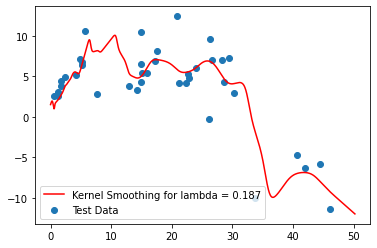

In [6]:
model = KernelRegression(GaussianKernel, 0.187)

# compute the model coordinates
xModel = np.linspace(0, 1.1 * np.max(X), 1000)
yModel = [model.predict(i, trainX, trainY) for i in xModel]

# plot the model
label = 'Kernel Smoothing for lambda = ' + str(0.187)
plt.scatter(testX, testY, label = 'Test Data')
plt.plot(xModel, yModel, 'r', label = label)
plt.legend()
    
# apply the functions to the test data and predict with the model
trainPredictions = [model.predict(i, trainX, trainY) for i in trainX]
testPredictions = [model.predict(i, trainX, trainY) for i in testX]
    
# compute the training and test mean absolute error
trainError = mean_absolute_error(trainY, trainPredictions)
testError = mean_absolute_error(testY, testPredictions)

# return quality metrics
print('lambda:', 0.187, '\t\tr^2:', np.round(r2_score(trainY, trainPredictions), 3),
      '\t\ttrain MAE:', np.round(trainError, 3), '\t\ttest MAE:', np.round(testError, 3))

## Problem 2

Let's simply modify the `gradientDescent` function from class. (Week 4, Lecture 9)

In [7]:
def computeGradient(f, x, h):
    # create a zero vector for the gradient
    n = len(x)
    gradient = np.zeros(n)
    
    # save f(x) so we don't need to compute it so frequently
    fx = f(x)
    
    # approximate the gradient
    for i in range(n):
        xUp = x.copy()
        
        # add h to the ith component of x
        xUp[i] += h
        
        # approximate the ith partial derivative
        gradient[i] = (f(xUp) - fx)/h
    
    # return the gredient
    return gradient

# run gradient descent and output the 
def gradientDescent(f, dimension, points, alpha, gamma, acceleration, h, tolerance, maxIterations, verbose = 1):
    x0 = np.random.uniform(-1, 1, size = (points, dimension))
    gradient = np.zeros([points, dimension])
    functionValue = np.zeros([points, 1])
    
    bestError = np.array([100000, 100000])
    for (i, x) in enumerate(x0):
        v = 0
        for counter in range(maxIterations):
            
            # update the gradient
            gradient[i] = computeGradient(f, x, h)

            # stop if the norm of the gradient is near 0
            if np.linalg.norm(gradient[i]) < tolerance:
                if verbose:
                    print('Gradient descent took', counter, 'iterations to converge')
                # return the approximate critical value x
                #return x
                break

            # if we do not converge, print a message
            elif counter == maxIterations-1:
                if verbose:
                    print("Gradient descent failed")
                # return x anyway
                #return x
                break
                
            # add Nesterov acceleration
            if acceleration:
                gradient[i] = computeGradient(f, x - gamma * v, h)

            # take a step with momentum
            v = gamma*v + alpha*gradient[i]
            x -= v
            
            functionValue[i] = f(x)

            if functionValue[i] < bestError[1]:
                bestError = [x, functionValue[i]]
    
    #if verbose:
    print('The minimum function value is', bestError[1])
        
    return bestError[0]

Let's run it with different values of gamma and with/without Nesterov acceleration on a simple example.

In [8]:
f = lambda x: x[0] ** 2
for gamma in np.linspace(0.0, 1.0, 11):
    print('\ngamma = ', np.round(gamma, 1))
    print('\nWITHOUT and then WITH Nesterov Acceleration:')
    print(gradientDescent(f, 1, 1, 0.01, gamma, 0, 0.0001, 0.01, 100000))
    print(gradientDescent(f, 1, 1, 0.01, gamma, 1, 0.0001, 0.01, 100000))


gamma =  0.0

WITHOUT and then WITH Nesterov Acceleration:
Gradient descent took 173 iterations to converge
The minimum function value is [2.37898792e-05]
[0.00487749]
Gradient descent took 199 iterations to converge
The minimum function value is [2.3993179e-05]
[0.00489828]

gamma =  0.1

WITHOUT and then WITH Nesterov Acceleration:
Gradient descent took 211 iterations to converge
The minimum function value is [2.39747297e-05]
[0.0048964]
Gradient descent took 217 iterations to converge
The minimum function value is [2.46256594e-05]
[-0.00496242]

gamma =  0.2

WITHOUT and then WITH Nesterov Acceleration:
Gradient descent took 140 iterations to converge
The minimum function value is [2.43758801e-05]
[-0.00493719]
Gradient descent took 151 iterations to converge
The minimum function value is [2.33943884e-05]
[0.00483677]

gamma =  0.3

WITHOUT and then WITH Nesterov Acceleration:
Gradient descent took 2 iterations to converge
The minimum function value is [2.4497937e-05]
[-0.00494954]

Let's also test with 10 different random starting points.

In [9]:
f = lambda x: x[0] ** 2
for gamma in np.linspace(0.0, 1.0, 11):
    print('\ngamma = ', np.round(gamma, 1))
    print(gradientDescent(f, 1, 10, 0.01, gamma, 1, 0.0001, 0.01, 100000, verbose = 0))


gamma =  0.0
The minimum function value is [2.36707886e-05]
[0.00486526]

gamma =  0.1
The minimum function value is [2.35290018e-05]
[0.00485067]

gamma =  0.2
The minimum function value is [2.34296742e-05]
[0.00484042]

gamma =  0.3
The minimum function value is [2.31424885e-05]
[0.00481066]

gamma =  0.4
The minimum function value is [2.28715787e-05]
[0.00478242]

gamma =  0.5
The minimum function value is [2.32608057e-05]
[0.00482295]

gamma =  0.6
The minimum function value is [2.25931266e-05]
[0.00475322]

gamma =  0.7
The minimum function value is [2.10688519e-05]
[0.00459008]

gamma =  0.8
The minimum function value is [1.65843445e-08]
[-0.00012878]

gamma =  0.9
The minimum function value is [4.9325944e-06]
[0.00222094]

gamma =  1.0
The minimum function value is [4.41186882e-07]
[0.00066422]


Let's use it for OLS with the `OrdinaryLeastSquaresGradient` class (modified for momentum and Nesterov acceleration) we constructed in lecture. (Week 4, Lecture 9)

In [10]:
class OrdinaryLeastSquaresGradient:
        
    # fit the model to the data
    def fit(self, X, y, x0, alpha, gamma, acceleration, h, tolerance, maxIterations):
        
        # save the training data
        X = np.hstack((np.ones([X.shape[0], 1]), X))
        
        # save the training labels
        output = y
        
        # find the theta values that minimize the sum of squared errors via gradient descent
        L = lambda theta: ((X @ theta).T - y.T) @ (X @ theta - y)
        self.theta = gradientDescent(L, X.shape[1], 10, alpha, gamma, acceleration, h, tolerance, maxIterations)
                
    # predict the output from testing data
    def predict(self, X):
        # initialize an empty matrix to store the predicted outputs
        yPredicted = np.empty([X.shape[0],1])
        
        # append a column of ones at the beginning of X
        X = np.hstack((np.ones([X.shape[0],1]), X))
        
        # apply the function f with the values of theta from the fit function to each testing datapoint (rows of X)
        for row in range(X.shape[0]):
            yPredicted[row] = self.theta @ X[row,]
            
        return yPredicted

In [11]:
# import the data from the csv file to an numpy array
data = pd.read_csv('../../data/US_State_Data.csv', sep=',').to_numpy()

# save into X and Y
X = np.array(data[:,1:8], dtype=float)
y = np.array(data[:,8], dtype=float)

# split the data into training and test sets
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.25, random_state = 1)

# standardize the data
trainX = scale(trainX)
testX = scale(testX)

# instantiate an OLS model
model = OrdinaryLeastSquaresGradient()

for gamma in np.linspace(0, 0.99, 20):
    print('\ngamma = ', np.round(gamma, 2))
    
    # with acceleration
    print('\n============================= ACCELERATION OFF =============================')
    
    # fit the model to the training data (find the theta parameters)
    model.fit(trainX, trainY, [0, 0, 0, 0, 0, 0, 0, 0], alpha = 0.005, gamma = gamma, acceleration = 0,
              h = 0.001, tolerance = 0.01, maxIterations = 100000)

    # return the predicted outputs for the datapoints in the training set
    trainPredictions = model.predict(trainX)

    # print the coefficient of determination r^2
    print('\nThe r^2 score is', r2_score(trainY, trainPredictions))

    # print quality metrics
    print('The mean absolute error on the training set is', mean_absolute_error(trainY, trainPredictions))

    # return the predicted outputs for the datapoints in the test set
    predictions = model.predict(testX)

    # print quality metrics
    print('The mean absolute error on the test set is', mean_absolute_error(testY, predictions))
    
    # with acceleration
    print('\n============================= ACCELERATION ON =============================')
    
    model.fit(trainX, trainY, [0, 0, 0, 0, 0, 0, 0, 0], alpha = 0.005, gamma = gamma, acceleration = 1,
              h = 0.001, tolerance = 0.01, maxIterations = 100000)

    # return the predicted outputs for the datapoints in the training set
    trainPredictions = model.predict(trainX)

    # print the coefficient of determination r^2
    print('\nThe r^2 score is', r2_score(trainY, trainPredictions))

    # print quality metrics
    print('The mean absolute error on the training set is', mean_absolute_error(trainY, trainPredictions))

    # return the predicted outputs for the datapoints in the test set
    predictions = model.predict(testX)

    # print quality metrics
    print('The mean absolute error on the test set is', mean_absolute_error(testY, predictions))


gamma =  0.0

============================= ACCELERATION OFF =============================
Gradient descent took 153 iterations to converge
Gradient descent took 167 iterations to converge
Gradient descent took 167 iterations to converge
Gradient descent took 159 iterations to converge
Gradient descent took 165 iterations to converge
Gradient descent took 164 iterations to converge
Gradient descent took 162 iterations to converge
Gradient descent took 164 iterations to converge
Gradient descent took 166 iterations to converge
Gradient descent took 163 iterations to converge
The minimum function value is [711.57884804]

The r^2 score is 0.4035247535658891
The mean absolute error on the training set is 3.6674117086612386
The mean absolute error on the test set is 4.004941227660132

============================= ACCELERATION ON =============================
Gradient descent took 169 iterations to converge
Gradient descent took 163 iterations to converge
Gradient descent took 163 iteratio

Note that the number of iterations gets smaller with momentum only until $\gamma=0.57$ (53-56 iterations) and acceleration starts to have a further reduction starting at $\gamma=0.63$ reaching a minimum of 40-42 iterations at $\gamma=0.68$.

## Problem 3

Let's bring in our `GaussianRBFnetwork` class from the lecture. (Week 4, Lecture 11)

We will modify the code to include $L^1$ and $L^2$ penalties, momentum, and Nesterov acceleration.

In [12]:
# create a RBF network class
class GaussianRBFnetwork:
    # initialize the model
    def __init__(self, d, M, alpha = 0.001, lambda1 = 0, lambda2 = 0,
                 gamma = 0, acceleration = 0, initialization = 'uniform'):
        
        # the dimension of the datapoints
        self.d = d
        
        # the number of radial basis functions
        self.M = M
                
        # the learning rate
        self.alpha = alpha
        
        # the L1 penalty coefficient
        self.lambda1 = lambda1
        
        # the L2 penalty coefficient
        self.lambda2 = lambda2
        
        # the momentum hyperparameter
        self.gamma = gamma
        
        # flag for Nesterov acceleration
        self.acceleration = acceleration
        
        # initialize the parameters
        if initialization == 'uniform':
            theta = 10 * np.random.uniform(-1, 1, size = (M + 1))
            lam = 10 * np.random.uniform(0, 1, size = (M))
            xi = 10 * np.random.uniform(-1, 1, size = (M, d))

        # save the initial parameters
        self.theta = theta
        self.lam = lam
        self.xi = xi
                
    # fit the model to some data X with labels y
    def fit(self, X, y, epochs = 1000, update = 10, annealing = False):
        self.n = X.shape[0]
        
        # save the training data
        X = np.hstack((np.ones([self.n, 1]), X))
        
        # initialize the kernel-weighted inputs
        XK = np.zeros([self.n, self.M])
        XK = np.hstack((np.ones([self.n, 1]), XK))
        
        # save the learning rate locally
        alpha = copy.copy(self.alpha)
        
        t = 0
        l = 0
        x = 0
        
        # run gradient descent with exact gradients
        for j in range(epochs):
            
            # adjust terms if we use Nesterov acceleration
            if self.acceleration:
                theta = self.theta - self.gamma * t
                lam = self.lam - self.gamma * l
                xi = self.xi - self.gamma * x
            else:
                theta = self.theta
                lam = self.lam
                xi = self.xi
            
            # compute the gradients ==================================================================================
            
            # theta gradient ################################
            
            # compute the kernel-weighted inputs
            for i in range(self.n):
                for k in range(self.M):
                    XK[i, k + 1] = self.GaussianKernel(X[i, 1:], self.xi[k], self.lam[k])
                        
            # training predictions         
            predictions = XK @ theta
            
            # compute the error
            error = predictions - y

            # compute theweighted error
            weightederror = np.atleast_2d(error).T * XK
            
            # compute the theta partial derivatives
            thetagrad = np.sum(weightederror, axis = 0)
            
            # lambda gradient ################################
            
            # compute the lambda partial derivatives
            term3 = np.zeros([self.n, self.M])
            for k in range(self.M):
                term3[:, k] = ((np.linalg.norm(xi[k] - X[:,1:], axis = 1)/lam[k]) ** 2 - 1) * theta[k]/lam[k]
            
            lamerror = term3 * weightederror[:, 1:]
            lamgrad = np.sum(lamerror, axis = 0)

            # xi gradient ####################################
            
            # compute the xi partial derivatives
            term4 = np.zeros([self.n, self.M, self.d])
            for k in range(self.M):
                for l in range(self.d):
                    term4[:, k, l] = (X[:, l] - xi[k, l]) * theta[k] / lam[k] ** 2

            xierror = term4 * np.atleast_3d(weightederror[:, 1:])
            xigrad = np.sum(xierror, axis = 0)
            
            # weight updates ===========================================================================================
            
            # add gradients of L1 and L2 penalties to gradients
            thetagrad += self.lambda1 * np.sign(theta) + 2 * self.lambda2 * theta
            lamgrad += self.lambda1 * np.sign(lam) + 2 * self.lambda2 * lam
            xigrad += self.lambda1 * np.sign(xi) + 2 * self.lambda2 * xi
            
            # weight updates with momentum or Nesterov acceleration
            t = self.gamma * t + self.alpha * thetagrad
            self.theta -= t
            
            l = self.gamma * l + self.alpha * lamgrad
            self.lam -= l
            
            x = self.gamma * x + self.alpha * xigrad
            self.xi -= x

            # ensure lambdas are positive
            self.lam = np.abs(self.lam)
                        
            # if the annealing variable is True, shrink the learning rate over time
            if annealing:
                self.alpha = (1 - j / epochs) * alpha
                
            # print a status update periodically
            if j % update == 0:
                print('Epoch', j, '\tLoss =', np.sum(error ** 2)/self.M)

    # compute predictions
    def predict(self, X):
        n = X.shape[0]
        X = np.hstack((np.ones([n, 1]), X))
        
        # initialize the kernel-weighted inputs
        XK = np.zeros([n, self.M])
        XK = np.hstack((np.ones([n, 1]), XK))
        
        # compute the kernel-weighted inputs
        for i in range(n):
            for k in range(self.M):
                XK[i, k + 1] = self.GaussianKernel(X[i, 1:], self.xi[k], self.lam[k])
                
        # training predictions
        predictions = XK @ self.theta

        return predictions
    
    # the Gaussian radial basis function
    def GaussianKernel(self, x, xi, lam):
        return (1/lam) * np.exp(-np.linalg.norm(x - xi) ** 2 / (2 * lam ** 2))

In [13]:
# read the data from the csv file
data = pd.read_csv('../data/homework-2-data.csv')

# delete rows with duplicate X's
data = data.drop_duplicates(subset = 'X', keep = 'first')

# extract the inputs X and outputs Y
X = data['X'].to_numpy()
Y = data['Y'].to_numpy()

# convert X to a n-by-1 matrix
X = np.atleast_2d(X).T

trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.4)
devX, testX, devY, testY = train_test_split(testX, testY, test_size = 0.5)

Epoch 0 	Loss = 1201.3208626740657
Epoch 1000 	Loss = 163.49864212922938
Epoch 2000 	Loss = 144.85693844134113
Epoch 3000 	Loss = 134.23077325109486
Epoch 4000 	Loss = 131.33044381019658
Epoch 5000 	Loss = 129.79827016344234
Epoch 6000 	Loss = 128.8862260368482
Epoch 7000 	Loss = 128.29669245502674
Epoch 8000 	Loss = 127.89115519115023
Epoch 9000 	Loss = 127.59786353871402
The r^2 score is 0.6876389305661614
The mean absolute error on the training set is 2.4760645779731316
The mean absolute error on the dev set is 2.3648647597716264


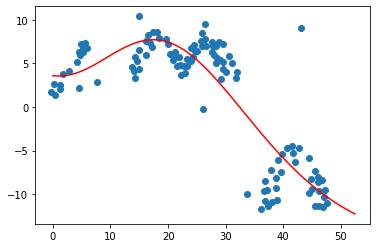

In [14]:
model = GaussianRBFnetwork(d = 1, M = 10, alpha = 0.01, gamma = 0.9, acceleration = 0,
                           lambda1 = 0, lambda2 = 0, initialization = 'uniform')

# fit the model
model.fit(trainX, trainY, epochs = 10000, update = 1000)

# predict the outputs
trainPredictions = model.predict(trainX)
devPredictions = model.predict(devX)

# compute the training and test mean absolute error
trainError = mean_absolute_error(trainY, trainPredictions)
devError = mean_absolute_error(devY, devPredictions)

# return quality metrics
print('The r^2 score is', r2_score(trainPredictions, trainY))
print('The mean absolute error on the training set is', trainError)
print('The mean absolute error on the dev set is', devError)

xModel = np.atleast_2d(np.linspace(0, 1.1 * np.max(X), 100)).T
yModel = model.predict(xModel)

# plot the training data
plt.scatter(trainX, trainY)

# plot the model
plt.plot(xModel, yModel, 'r')

The fit isn't amazing, but it certainly captures general trends in the data. (More experiments should be done with cross-validation for hyperparameter tuning.)